--- 1. INITIAL STATE (BEFORE CLEANING) ---
Total Rows: 9994

Empty Values per Column:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Data Types Before:
Order Date    object
Ship Date     object
dtype: object

--- 2. VACUUM & INTEGRITY CHECK ---
Missing Data Ratio: 0.00%
Action: No empty data found. No deletion needed.

--- 3. FINAL STATE (CLEANED) ---
Final Row Count: 9994

--- 4. SUB-CATEGORY PROFITABILITY DATA ---
   Sub-Category        Sales      Profit  Discount
16       Tables  206965.5320 -17725.4811  0.261285
4     Bookcases  114879.9963  -3472.5560  0.211140
15     Supplies   46673.5380  -1189.0995  0.076842
8     Fast

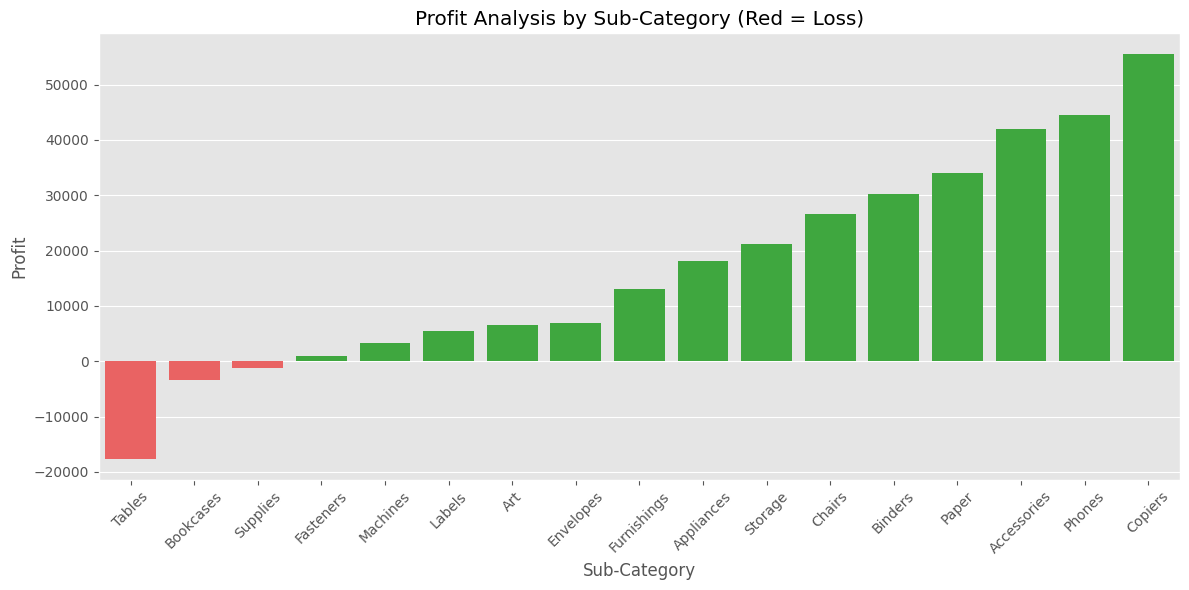

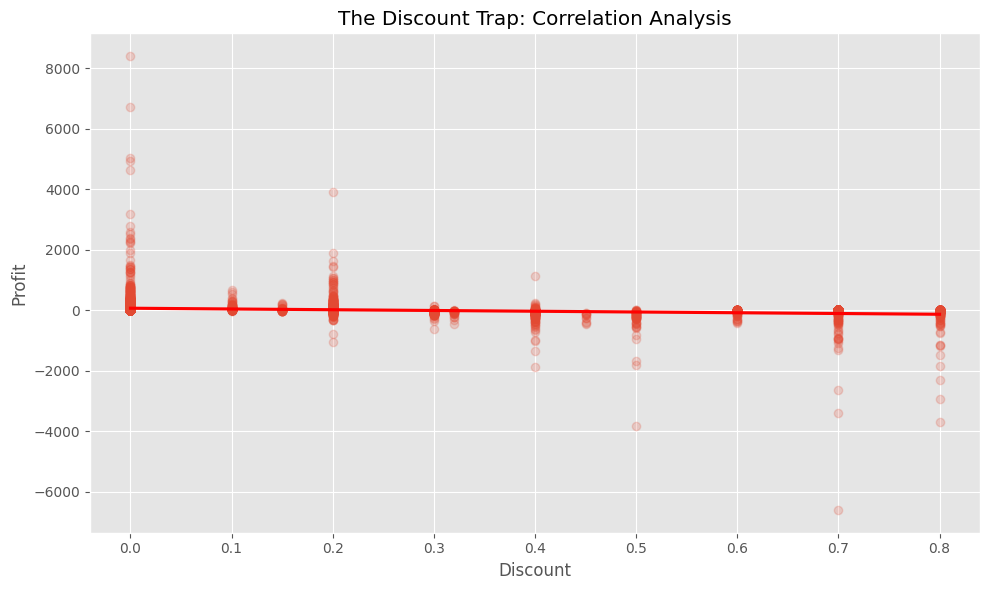

In [ ]:
+import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from openai import OpenAI

warnings.filterwarnings('ignore')

def load_and_smart_clean(file_path):
    df = pd.read_csv(file_path, encoding='latin1')

    print(f"Total Rows: {len(df)}")
    print("\nEmpty Values per Column:")
    print(df.isnull().sum())

    print("\nData Types Before:")
    print(df[['Order Date', 'Ship Date']].dtypes)

    total_cells = np.prod(df.shape)
    total_missing = df.isnull().sum().sum()
    missing_ratio = (total_missing / total_cells) * 100

    print(f"\nMissing Data Ratio: {missing_ratio:.2f}%")

    if 0 < missing_ratio < 5:
        df = df.dropna()
    elif missing_ratio >= 5:
        pass

    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])
    df['Profit Margin %'] = (df['Profit'] / df['Sales']) * 100

    print(f"\nFinal Row Count: {len(df)}")
    return df

def perform_analysis(df):
    subcat_metrics = df.groupby('Sub-Category').agg({
        'Sales': 'sum',
        'Profit': 'sum',
        'Discount': 'mean'
    }).reset_index()

    print(subcat_metrics.sort_values(by='Profit'))

    top_losers = subcat_metrics.sort_values(by='Profit').head(3)
    worst_item = top_losers.iloc[0]['Sub-Category']

    worst_item_df = df[df['Sub-Category'] == worst_item]
    regional_metrics = worst_item_df.groupby('Region')['Profit'].sum().reset_index().sort_values(by='Profit')
    worst_region = regional_metrics.iloc[0]['Region']

    print(regional_metrics)

    return subcat_metrics, top_losers, worst_item, worst_region

def create_visuals(df, subcat_metrics):
    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    sorted_subcats = subcat_metrics.sort_values(by='Profit')
    colors = ['#ff4d4d' if x < 0 else '#2eb82e' for x in sorted_subcats['Profit']]
    sns.barplot(data=sorted_subcats, x='Sub-Category', y='Profit', palette=colors)
    plt.title('Profit Analysis by Sub-Category (Red = Loss)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('profit_analysis.png')

    plt.figure(figsize=(10, 6))
    sns.regplot(
        data=df,
        x='Discount',
        y='Profit',
        scatter_kws={'alpha': 0.2},
        line_kws={"color": "red"}
    )
    plt.title('Discount vs Profit Analysis')
    plt.tight_layout()
    plt.savefig('discount_impact.png')

def generate_ai_report(top_losers, worst_item, worst_region):
    GROQ_API_KEY = "api"
    client = OpenAI(
        base_url="https://api.groq.com/openai/v1",
        api_key=GROQ_API_KEY
    )

    summary_table = top_losers.to_string(index=False)

    prompt = f"""
    Context Data:
    {summary_table}

    Worst Category: {worst_item}
    Worst Region: {worst_region}

    Provide an executive summary using numerical evidence.
    """

    response = client.chat.completions.create(
        model="llama-3.3-70b-versatile",
        messages=[
            {"role": "system", "content": "You are a professional business consultant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

if __name__ == "__main__":
    file = 'Sample - Superstore.csv'

    try:
        data = load_and_smart_clean(file)
        metrics, losers, item, region = perform_analysis(data)
        create_visuals(data, metrics)
        report = generate_ai_report(losers, item, region)
        print(report)

    except FileNotFoundError:
        print(f"Error: Could not find '{file}'.")
    except Exception as e:
        print(f"Error: {e}")
